# Building a tokenizer, block by block


As we’ve seen in the previous sections, tokenization comprises several steps:

* Normalization (any cleanup of the text that is deemed necessary, such as removing spaces or accents, Unicode normalization, etc.)

* Pre-tokenization (splitting the input into words)

* Running the input through the model (using the pre-tokenized words to produce a sequence of tokens)

* Post-processing (adding the special tokens of the tokenizer, generating the attention mask and token type IDs)

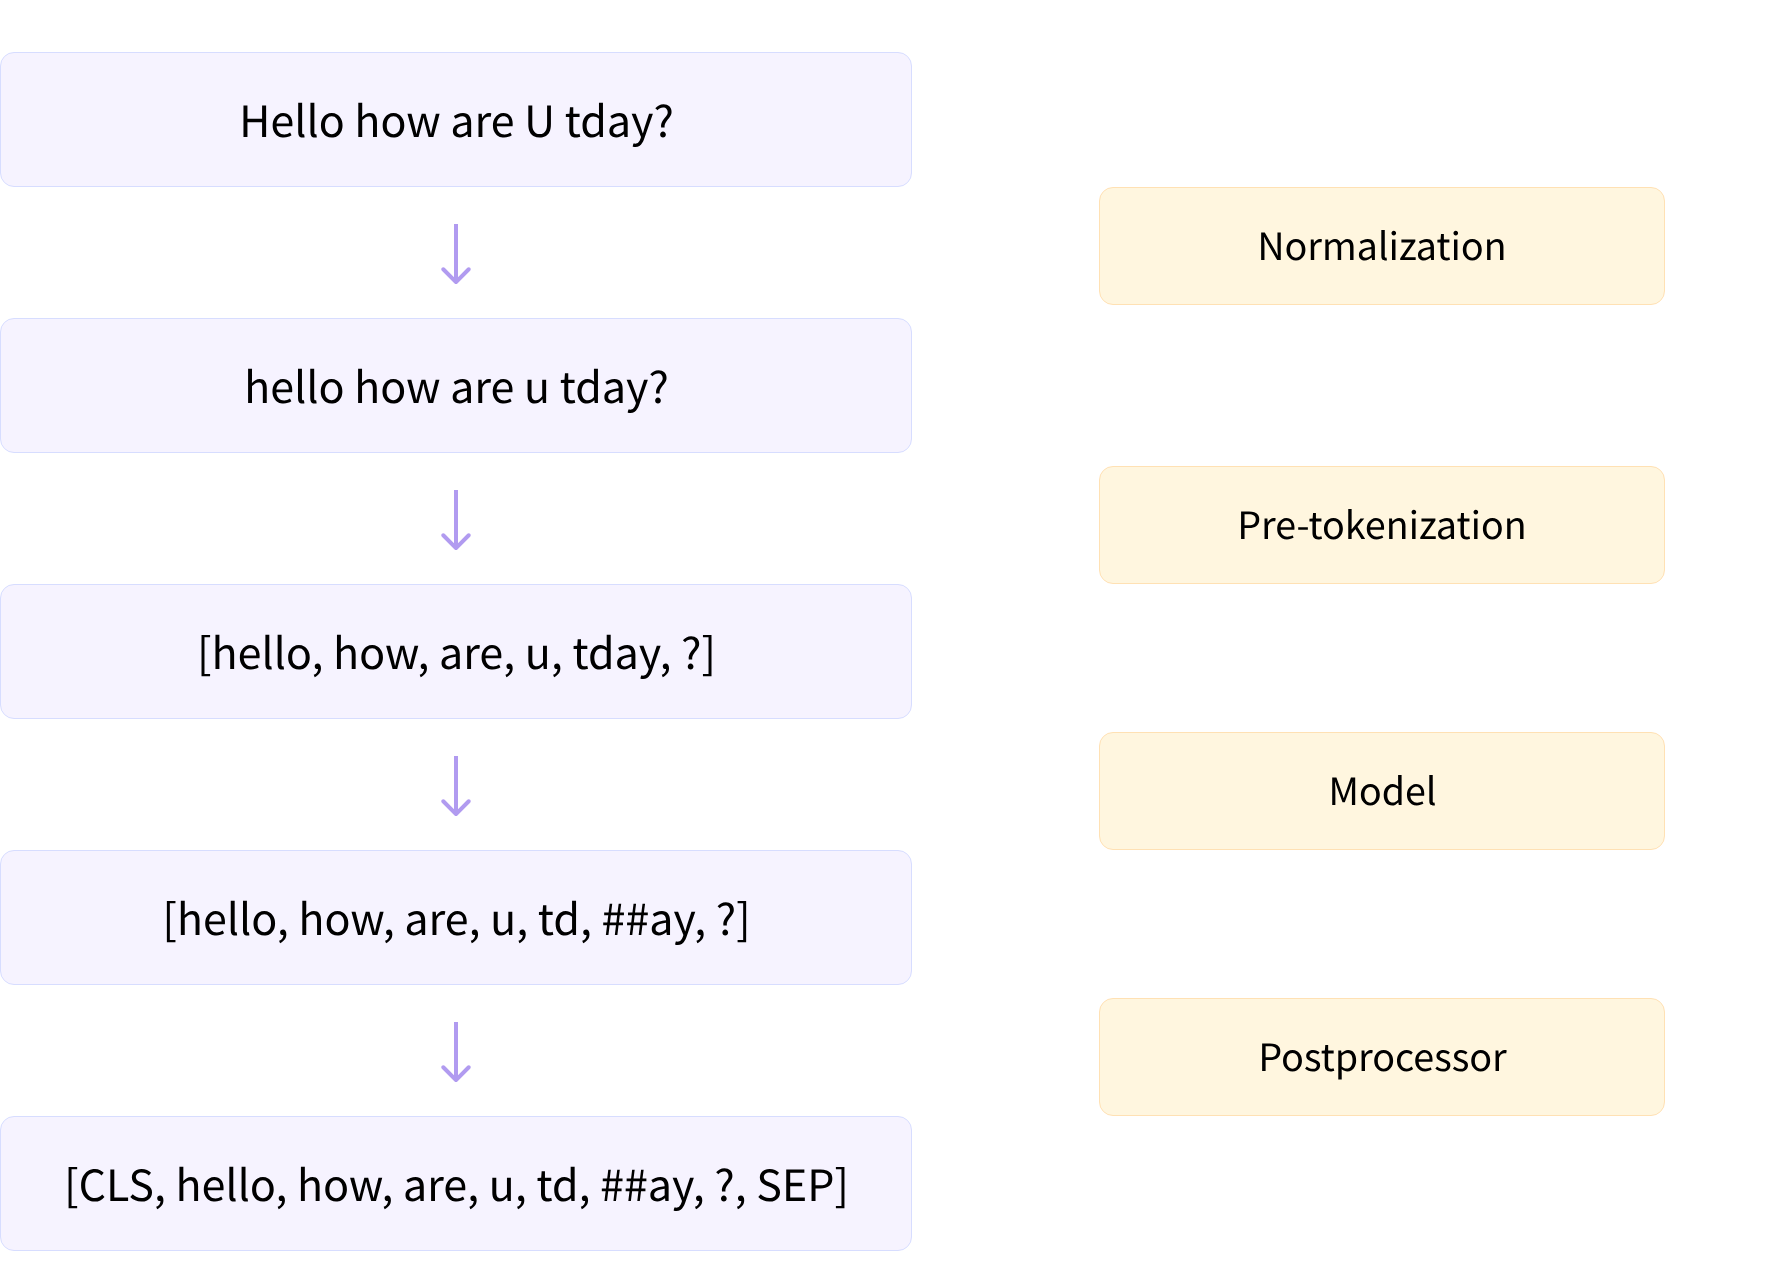

The 🤗 Tokenizers library has been built to provide several options for each of those steps, which you can mix and match together. In this section we’ll see how we can build a tokenizer from scratch, as opposed to training a new tokenizer from an old one.

More precisely, the library is built around a central Tokenizer class with the building blocks regrouped in submodules:

* `normalizers` contains all the possible types of Normalizer you can use.

* `pre_tokenizers` contains all the possible types of PreTokenizer you can use.

* `models` contains the various types of Model you can use, like BPE, WordPiece, and Unigram.

* `trainers` contains all the different types of Trainer you can use to train your model on a corpus (one per type of model).

* `post_processors` contains the various types of PostProcessor you can use.

* `decoders` contains the various types of Decoder you can use to decode the outputs of tokenization.

## 1. Acquiring a corpus


This time, we will use the WikiText2 dataset.

In [1]:
from datasets import load_dataset

dataset = load_dataset("wikitext", name="wikitext-2-raw-v1", split="train")

README.md: 0.00B [00:00, ?B/s]

c:\Users\DELL\.conda\envs\torch_env\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\DELL\.cache\huggingface\hub\datasets--wikitext. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [10]:
dataset[:2]

{'text': ['', ' = Valkyria Chronicles III = \n']}

In [47]:
def get_training_corpus():
    for i in range(0, len(dataset), 1000):
        yield dataset[i: i + 1000]["text"]

The function `get_training_corpus()` is a generator that will yield batches of 1,000 texts, which we will use to train the tokenizer.



🤗 Tokenizers can also be trained on text files directly. Here’s how we can generate a text file containing all the texts/inputs from WikiText-2 that we can use locally:



In [24]:
with open("wikitext-2.txt", 'w', encoding='utf-8') as f:
    for i in range(len(dataset)):
        f.write(dataset[i]["text"] + '\n')

Next we’ll show you how to build your own BERT, GPT-2, and XLNet tokenizers, block by block. That will give us an example of each of the three main tokenization algorithms: WordPiece, BPE, and Unigram. Let’s start with BERT!



## 2. Building a WordPiece tokenizer from scratch


To build a tokenizer with the 🤗 Tokenizers library, we start by instantiating a `Tokenizer` object with a model, then set its `normalizer`, `pre_tokenizer`, `post_processor`, and `decoder` attributes to the values we want.



In [12]:
from tokenizers import (
    decoders, 
    pre_tokenizers,
    normalizers,
    models, 
    processors,
    trainers, 
    Tokenizer
)

tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))

We have to specify the `unk_token` so the model knows what to return when it encounters characters it hasn’t seen before. Other arguments we can set here include the `vocab` of our model (we’re going to train the model, so we don’t need to set this) and `max_input_chars_per_word`, which specifies a maximum length for each word (words longer than the value passed will be split).



The first step of tokenization is normalization, so let’s begin with that. Since BERT is widely used, there is a `BertNormalizer` with the classic options we can set for BERT: `lowercase` and `strip_accents`, which are self-explanatory; `clean_text` to remove all control characters and replace repeating spaces with a single one; and `handle_chinese_chars`, which places spaces around Chinese characters. To replicate the `bert-base-uncased` tokenizer, we can just set this normalizer:



In [13]:
tokenizer.normalizer = normalizers.BertNormalizer(lowercase=True)

Generally speaking, however, when building a new tokenizer you won’t have access to such a handy normalizer already implemented in the 🤗 Tokenizers library — so let’s see how to create the BERT normalizer by hand. The library provides a `Lowercase` normalizer and a `StripAccents` normalizer, and you can compose several normalizers using a `Sequence`:



In [14]:
tokenizer.normalizer = normalizers.Sequence(
    [normalizers.NFD(), normalizers.Lowercase(), normalizers.StripAccents()]
)

We’re also using an `NFD` Unicode normalizer, as otherwise the `StripAccents` normalizer won’t properly recognize the accented characters and thus won’t strip them out.



We can use the `normalize_str()` method of the normalizer to check out the effects it has on a given text:

In [15]:
print(tokenizer.normalizer.normalize_str("Héllò hôw are ü?"))


hello how are u?


Next is the pre-tokenization step. Again, there is a prebuilt `BertPreTokenizer` that we can use:



In [16]:
tokenizer.pre_tokenizer = pre_tokenizers.BertPreTokenizer()


Or we can build it from scratch:



In [ ]:
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()


Note that the `Whitespace` pre-tokenizer splits on whitespace and all characters that are not letters, digits, or the underscore character, so it technically splits on whitespace and punctuation:



In [18]:
tokenizer.pre_tokenizer.pre_tokenize_str("Let's test my pre-tokenizer.")


[('Let', (0, 3)),
 ("'", (3, 4)),
 ('s', (4, 5)),
 ('test', (6, 10)),
 ('my', (11, 13)),
 ('pre', (14, 17)),
 ('-', (17, 18)),
 ('tokenizer', (18, 27)),
 ('.', (27, 28))]

If you only want to split on whitespace, you should use the `WhitespaceSplit` pre-tokenizer instead:



In [19]:
pre_tokenizer = pre_tokenizers.WhitespaceSplit()
pre_tokenizer.pre_tokenize_str("Let's test my pre-tokenizer.")

[("Let's", (0, 5)),
 ('test', (6, 10)),
 ('my', (11, 13)),
 ('pre-tokenizer.', (14, 28))]

Like with normalizers, you can use a `Sequence` to compose several pre-tokenizers:



In [20]:
pre_tokenizer = pre_tokenizers.Sequence(
    [pre_tokenizers.WhitespaceSplit(), pre_tokenizers.Punctuation()]
)
pre_tokenizer.pre_tokenize_str("Let's test my pre-tokenizer.")


[('Let', (0, 3)),
 ("'", (3, 4)),
 ('s', (4, 5)),
 ('test', (6, 10)),
 ('my', (11, 13)),
 ('pre', (14, 17)),
 ('-', (17, 18)),
 ('tokenizer', (18, 27)),
 ('.', (27, 28))]

The next step in the tokenization pipeline is running the inputs through the model. We already specified our model in the initialization, but we still need to train it, which will require a `WordPieceTrainer`. The main thing to remember when instantiating a `trainer` in 🤗 Tokenizers is that you need to pass it all the special tokens you intend to use — otherwise it won’t add them to the vocabulary, since they are not in the training corpus:



In [26]:
special_tokens = ["[UNK]", "[MASK]", "[SEP]", "[CLS]", "[PAD]"]
trainer = trainers.WordPieceTrainer(vocab_size=52000, special_tokens=special_tokens)

As well as specifying the `vocab_size` and `special_tokens`, we can set the `min_frequency` (the number of times a token must appear to be included in the vocabulary) or change the `continuing_subword_prefix` (if we want to use something different from `##`).



To train our model using the iterator we defined earlier, we just have to execute this command:



In [27]:
tokenizer.model = models.WordPiece(unk_token='[UNK]')
tokenizer.train(["wikitext-2.txt"], trainer=trainer)

In both cases, we can then test the tokenizer on a text by calling the `encode()` method:



In [30]:
encoding = tokenizer.encode("Let's test this tokenizer right away!")
print(encoding)
print(encoding.ids)
print(encoding.type_ids)
print(encoding.tokens)
print(encoding.offsets)
print(encoding.attention_mask)
print(encoding.special_tokens_mask)
print(encoding.overflowing)

Encoding(num_tokens=10, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
[3019, 11, 61, 3611, 1519, 39013, 13840, 2565, 2850, 5]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['let', "'", 's', 'test', 'this', 'token', '##izer', 'right', 'away', '!']
[(0, 3), (3, 4), (4, 5), (6, 10), (11, 15), (16, 21), (21, 25), (26, 31), (32, 36), (36, 37)]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[]


The encoding obtained is an `Encoding`, which contains all the necessary outputs of the tokenizer in its various attributes: `ids`, `type_ids`, `tokens`, `offsets`, `attention_mask`, `special_tokens_mask`, and `overflowing`.



The last step in the tokenization pipeline is post-processing. We need to add the `[CLS]` token at the beginning and the `[SEP]` token at the end (or after each sentence, if we have a pair of sentences). We will use a `TemplateProcessor` for this, but first we need to know the IDs of the `[CLS]` and `[SEP]` tokens in the vocabulary:



In [31]:
cls_token_id = tokenizer.token_to_id('[CLS]')
sep_token_id = tokenizer.token_to_id('[SEP]')
print(cls_token_id, sep_token_id)

3 2


To write the template for the `TemplateProcessor`, we have to specify how to treat a single sentence and a pair of sentences. For both, we write the special tokens we want to use; the first (or single) sentence is represented by `$A`, while the second sentence (if encoding a pair) is represented by `$B`. For each of these (special tokens and sentences), we also specify the corresponding token type ID after a colon.



In [32]:
tokenizer.post_processor = processors.TemplateProcessing(
    single=f'[CLS]:0 $A:0 [SEP]:0',
    pair=f'[CLS]:0 $A:0 [SEP]:0 $B:1 [SEP]:1',
    special_tokens=[('[CLS]', cls_token_id), ('[SEP]', sep_token_id)]
)

Note that we need to pass along the IDs of the special tokens, so the tokenizer can properly convert them to their IDs.



Once this is added, going back to our previous example will give:



In [33]:
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)

['[CLS]', 'let', "'", 's', 'test', 'this', 'token', '##izer', '.', '[SEP]']


And on a pair of sentences, we get the proper result:



In [34]:
encoding = tokenizer.encode("Let's test this tokenizer...", "on a pair of sentences.")
print(encoding.tokens)
print(encoding.type_ids)

['[CLS]', 'let', "'", 's', 'test', 'this', 'token', '##izer', '...', '[SEP]', 'on', 'a', 'pair', 'of', 'sentences', '.', '[SEP]']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]


We’ve almost finished building this tokenizer from scratch — the last step is to include a decoder:



In [35]:
tokenizer.decoder = decoders.WordPiece(prefix="##")


Let’s test it on our previous `encoding`:



In [36]:
tokenizer.decode(encoding.ids)


"let ' s test this tokenizer... on a pair of sentences."

Great! We can save our tokenizer in a single JSON file like this:



In [37]:
tokenizer.save("tokenizer.json")


We can then reload that file in a `Tokenizer` object with the `from_file()` method:



In [38]:
new_tokenizer = Tokenizer.from_file("tokenizer.json")

To use this tokenizer in 🤗 Transformers, we have to wrap it in a `PreTrainedTokenizerFast`. We can either use the generic class or, if our tokenizer corresponds to an existing model, use that class (here, `BertTokenizerFast`). If you apply this lesson to build a brand new tokenizer, you will have to use the first option.



To wrap the tokenizer in a `PreTrainedTokenizerFast`, we can either pass the tokenizer we built as a `tokenizer_object` or pass the tokenizer file we saved as `tokenizer_file`. The key thing to remember is that we have to manually set all the special tokens, since that class can’t infer from the tokenizer object which token is the mask token, the `[CLS]` token, etc.:



In [39]:
from transformers import PreTrainedTokenizerFast

wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    unk_token='[UNK]',
    mask_token='[MASK]',
    sep_token='[SEP]',
    cls_token='[CLS]',
    pad_token='[PAD]'
)

If you are using a specific tokenizer class (like `BertTokenizerFast`), you will only need to specify the special tokens that are different from the default ones (here, none):



In [40]:
from transformers import BertTokenizerFast

wrapped_tokenizer = BertTokenizerFast(tokenizer_object=tokenizer)

You can then use this tokenizer like any other 🤗 Transformers tokenizer. You can save it with the `save_pretrained()` method, or upload it to the Hub with the `push_to_hub()` method.



Now that we’ve seen how to build a WordPiece tokenizer, let’s do the same for a BPE tokenizer. We’ll go a bit faster since you know all the steps, and only highlight the differences.



## 3. Building a BPE tokenizer from scratch


Let’s now build a GPT-2 tokenizer. Like for the BERT tokenizer, we start by initializing a `Tokenizer` with a BPE model:



In [41]:
tokenizer = Tokenizer(models.BPE())

Also like for BERT, we could initialize this model with a vocabulary if we had one (we would need to pass the `vocab` and `merges` in this case), but since we will train from scratch, we don’t need to do that. We also don’t need to specify an `unk_token` because GPT-2 uses byte-level BPE, which doesn’t require it.



GPT-2 does not use a normalizer, so we skip that step and go directly to the pre-tokenization:



In [44]:
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)

The option we added to `ByteLevel` here is to not add a space at the beginning of a sentence (which is the default otherwise). We can have a look at the pre-tokenization of an example text like before:



In [45]:
tokenizer.pre_tokenizer.pre_tokenize_str("Let's test pre-tokenization!")


[('Let', (0, 3)),
 ("'s", (3, 5)),
 ('Ġtest', (5, 10)),
 ('Ġpre', (10, 14)),
 ('-', (14, 15)),
 ('tokenization', (15, 27)),
 ('!', (27, 28))]

Next is the model, which needs training. For GPT-2, the only special token is the end-of-text token:



In [48]:
trainer = trainers.BpeTrainer(vocab_size=52000, special_tokens=["<|endoftext|>"])
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

Like with the `WordPieceTrainer`, as well as the `vocab_size` and `special_tokens`, we can specify the `min_frequency` if we want to, or if we have an `end-of-word` suffix (like `</w>`), we can set it with `end_of_word_suffix`.

This tokenizer can also be trained on text files:



In [49]:
tokenizer.model = models.BPE()
tokenizer.train(["wikitext-2.txt"], trainer=trainer)

Let’s have a look at the tokenization of a sample text:



In [50]:
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)

['L', 'et', "'", 's', 'Ġtest', 'Ġthis', 'Ġtoken', 'izer', '.']


We apply the byte-level post-processing for the GPT-2 tokenizer as follows:



In [51]:
tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)

The `trim_offsets = False` option indicates to the post-processor that we should leave the offsets of tokens that begin with `‘Ġ’` as they are: this way the start of the offsets will point to the space before the word, not the first character of the word (since the space is technically part of the token). Let’s have a look at the result with the text we just encoded, where `'Ġtest'` is the token at index 4:



In [52]:
sentence = "Let's test this tokenizer."
encoding = tokenizer.encode(sentence)
start, end = encoding.offsets[4]
sentence[start:end]

' test'

Finally, we add a byte-level decoder:



In [53]:
tokenizer.decoder = decoders.ByteLevel()

and we can double-check it works properly:



In [54]:
tokenizer.decode(encoding.ids)

"Let's test this tokenizer."

Great! Now that we’re done, we can save the tokenizer like before, and wrap it in a `PreTrainedTokenizerFast` or `GPT2TokenizerFast` if we want to use it in 🤗 Transformers:



In [55]:
from transformers import PreTrainedTokenizerFast

wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    bos_token='<|endoftext|>',
    eos_token='<|endoftext|>'
)

or:

In [59]:
from transformers import GPT2TokenizerFast

wrapped_tokenizer = GPT2TokenizerFast(tokenizer_object=tokenizer)

## 4. Building a Unigram tokenizer from scratch


Let’s now build an XLNet tokenizer. Like for the previous tokenizers, we start by initializing a `Tokenizer` with a Unigram model:



In [60]:
tokenizer = Tokenizer(models.Unigram())

Again, we could initialize this model with a vocabulary if we had one.



For the normalization, XLNet uses a few replacements (which come from SentencePiece):



In [62]:
from tokenizers import Regex

tokenizer.normalizer = normalizers.Sequence(
    [
        normalizers.Replace("``", '"'),
        normalizers.Replace("''", '"'),
        normalizers.NFKD(),
        normalizers.StripAccents(),
        normalizers.Replace(Regex(" {2,}"), " ")
    ]
)

The pre-tokenizer to use for any SentencePiece tokenizer is `Metaspace`:



In [63]:
tokenizer.pre_tokenizer = pre_tokenizers.Metaspace()

We can have a look at the pre-tokenization of an example text like before:



In [64]:
tokenizer.pre_tokenizer.pre_tokenize_str("Let's test the pre-tokenizer!")

[("▁Let's", (0, 5)),
 ('▁test', (5, 10)),
 ('▁the', (10, 14)),
 ('▁pre-tokenizer!', (14, 29))]

Next is the model, which needs training. XLNet has quite a few special tokens:



In [65]:
special_tokens = ['<cls>', '<sep>', '<unk>', '<pad>', '<mask>', '<s>', '</s>']
trainer = trainers.UnigramTrainer(
    vocab_size=52000, special_tokens=special_tokens, unk_token='<unk>'
)
tokenizer.train_from_iterator(get_training_corpus(), trainer=trainer)

A very important argument not to forget for the `UnigramTrainer` is the `unk_token`. We can also pass along other arguments specific to the Unigram algorithm, such as the `shrinking_factor` for each step where we remove tokens (defaults to 0.75) or the `max_piece_length` to specify the maximum length of a given token (defaults to 16).



This tokenizer can also be trained on text files:



In [66]:
tokenizer.model = models.Unigram()
tokenizer.train(["wikitext-2.txt"], trainer=trainer)

Let’s have a look at the tokenization of a sample text:



In [67]:
encoding = tokenizer.encode("Let's test this tokenizer.")
print(encoding.tokens)

['▁Let', "'s", '▁test', '▁this', '▁to', 'ken', 'izer', '.']


A peculiarity of XLNet is that it puts the `<cls>` token at the end of the sentence, with a type ID of 2 (to distinguish it from the other tokens). It’s padding on the left, as a result. We can deal with all the special tokens and token type IDs with a template, like for BERT, but first we have to get the IDs of the `<cls>` and `<sep>` tokens:



In [68]:
cls_token_id = tokenizer.token_to_id('<cls>')
sep_token_id = tokenizer.token_to_id('<sep>')
print(cls_token_id, sep_token_id)

0 1


The template looks like this:



In [69]:
tokenizer.post_processor = processors.TemplateProcessing(
    single='$A:0 <sep>:0 <cls>:2',
    pair='$A:0 <sep>:0 $B:1 <sep>:1 <cls>:2',
    special_tokens=[("<sep>", sep_token_id), ("<cls>", cls_token_id)]
)

And we can test it works by encoding a pair of sentences:



In [70]:
encoding = tokenizer.encode("Let's test this tokenizer...", "on a pair of sentences!")
print(encoding.tokens)
print(encoding.type_ids)

['▁Let', "'s", '▁test', '▁this', '▁to', 'ken', 'izer', '.', '.', '.', '<sep>', '▁', 'on', '▁', 'a', '▁pair', '▁of', '▁sentence', 's', '!', '<sep>', '<cls>']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]


Finally, we add a `Metaspace` decoder:



In [71]:
tokenizer.decoder = decoders.Metaspace()


One thing to note when using `PreTrainedTokenizerFast` is that on top of the special tokens, we need to tell the 🤗 Transformers library to pad on the left:

In [72]:
from transformers import PreTrainedTokenizerFast

wrapped_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tokenizer,
    bos_token='<s>',
    eos_token='</s>',
    unk_token='<unk>',
    pad_token='<pad>',
    mask_token='<mask>',
    cls_token='<cls>',
    sep_token='<sep>',
    padding_side="left"
)

Or alternatively:



In [73]:
from transformers import XLNetTokenizerFast

wrapped_tokenizer = XLNetTokenizerFast(tokenizer_object=tokenizer)